<a href="https://colab.research.google.com/github/freddy0218/2022_ML_Earth_Env_Sci/blob/main/Lab_Notebooks/S3_4_Wildfire_Risk_Italy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In week 3's final notebook, we will train classifiers on real [wildfire](https://en.wikipedia.org/wiki/Wildfire) data to map the fire risk in different regions of Italy. To keep the data size manageable, we will focus on the coastal [Liguria region](https://en.wikipedia.org/wiki/Liguria) that experiences a lot of wildfires, especially during the winter. 



---



**Credits**

This online tutorial would not be possible without invaluable contributions from [Andrea Trucchia](https://www.researchgate.net/profile/Andrea-Trucchia) (reduced data, methods), [Giorgio Meschi](https://www.linkedin.com/in/giorgio-meschi-86216b180/) (code, methods), and [Marj Tonini](https://www.researchgate.net/profile/Marj-Tonini-2) (presentation, methods). The methodology builds upon the following article:

[Trucchia, A.; Meschi, G.; Fiorucci, P.; Gollini, A.; Negro, D., Defining Wildfire Susceptibility Maps in Italy for Understanding Seasonal Wildfire Regimes at the National Level, *Fire*, (2022)](https://www.mdpi.com/2571-6255/5/1/30) 

which generalizes the study below from the Liguria region (our case study) to all of Italy:

[Tonini, Marj, et al. "A machine learning-based approach for wildfire susceptibility mapping. The case study of the Liguria region in Italy." *Geosciences* 10.3 (2020): 105.](https://www.mdpi.com/2076-3263/10/3/105)



---



# Exercise 4: Mapping Wildfire Susceptibility in the Liguria Region with Simple Machine Learning Classifiers

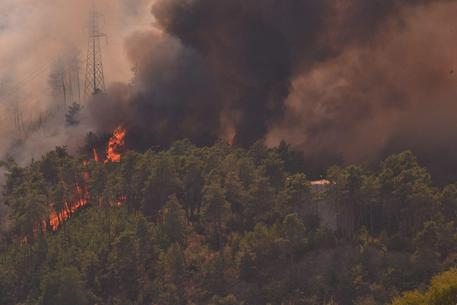

**Caption**: A wildfire in Italy. Can we predict which locations are most susceptible to wildfires using simple classifiers? 🔥

**Source**: [ANSA](https://www.ansa.it/english/news/2015/08/14/wildfires-in-italy-up-120-this-summer-on-past-two-years_f6e4eff7-ac07-4f9e-aa5a-e61f8c2ad7f2.html)

Let's start by downloading and loading the datasets into memory using the [`pooch`](https://pypi.org/project/pooch/), [`pickle5`](https://pypi.org/project/pickle5/), and [`GeoPandas`](https://geopandas.org/en/stable/) libraries:

In [1]:
# Install geopandas and pickle5
%pip install geopandas
%pip install pickle5

     |████████████████████████████████| 1.0 MB 19.4 MB/s 
     |████████████████████████████████| 6.3 MB 51.2 MB/s 
     |████████████████████████████████| 16.7 MB 55.1 MB/s 
     |████████████████████████████████| 256 kB 10.6 MB/s 


In [1]:
import geopandas as gpd
import numpy as np
import pickle5 as pickle
import pooch

In [2]:
# Function to load the data
def load_data(path):
    
    # Load the content of the pickle file (using pickle5 for Google Colab)
    with open(path, "rb") as fh:
        points_df = pickle.load(fh)

    # Convert it to a Geopandas `GeoDataFrame` for spatial analysis
    points_df = gpd.GeoDataFrame(points_df, 
                                 geometry=gpd.points_from_xy(np.float64(points_df.x), 
                                                             np.float64(points_df.y))) 
    return points_df

In [3]:
# Path to the data in UNIL OneDrive
variables_path = pooch.retrieve('https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EU4FQkuYknFDiDfd7droyAcBP0qFOR5-c-_Oq74gjhTGwQ?download=1',
                            known_hash='e8ebc70f972b5af4ef3d6110dcd61ce01ce5a830dcdb7d2c9e737aeab781606c')
wildfires_path = pooch.retrieve('https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EcjqeERsnIRHjhcx1ZFVNggBS7nPUkW530XRrpVUB-qnOw?download=1',
                             known_hash='361f067aafbac8add8f8a9a5c630df3c962cd37a2f125f420e7b9330fd0a1a4c')

In [4]:
# Load the data and convert it to a GeoPandas `GeoDataFrame`
# This can take a minute
variables = load_data(variables_path)
wildfires = load_data(wildfires_path)

## Part I: Pre-Processing the Dataset for Classification

**Q1) After analyzing the topography and land cover data provided in `variables`, create your input dataset `inputs` from `variables` to predict the occurence of wildfires (`wildfires`). Keep at least one categorical variable (`veg`, `bioclim`, or `phytoclim`).**

Hint 1: Refer to the documentation [at this link](https://unils-my.sharepoint.com/:t:/g/personal/tom_beucler_unil_ch/EREf92h-43VBtgPjwveMfrQBRahitmHxBKAtNx04lleh7Q?e=Fx6nad) to know what the different `keys` of `variables` refer to.

Hint 2: You may refer to Table 1 of [Tonini et al.](https://www.mdpi.com/2076-3263/10/3/105), copied below, to choose your input variables, although we recommend starting with less inputs at first to build a simpler model and avoid overfitting.

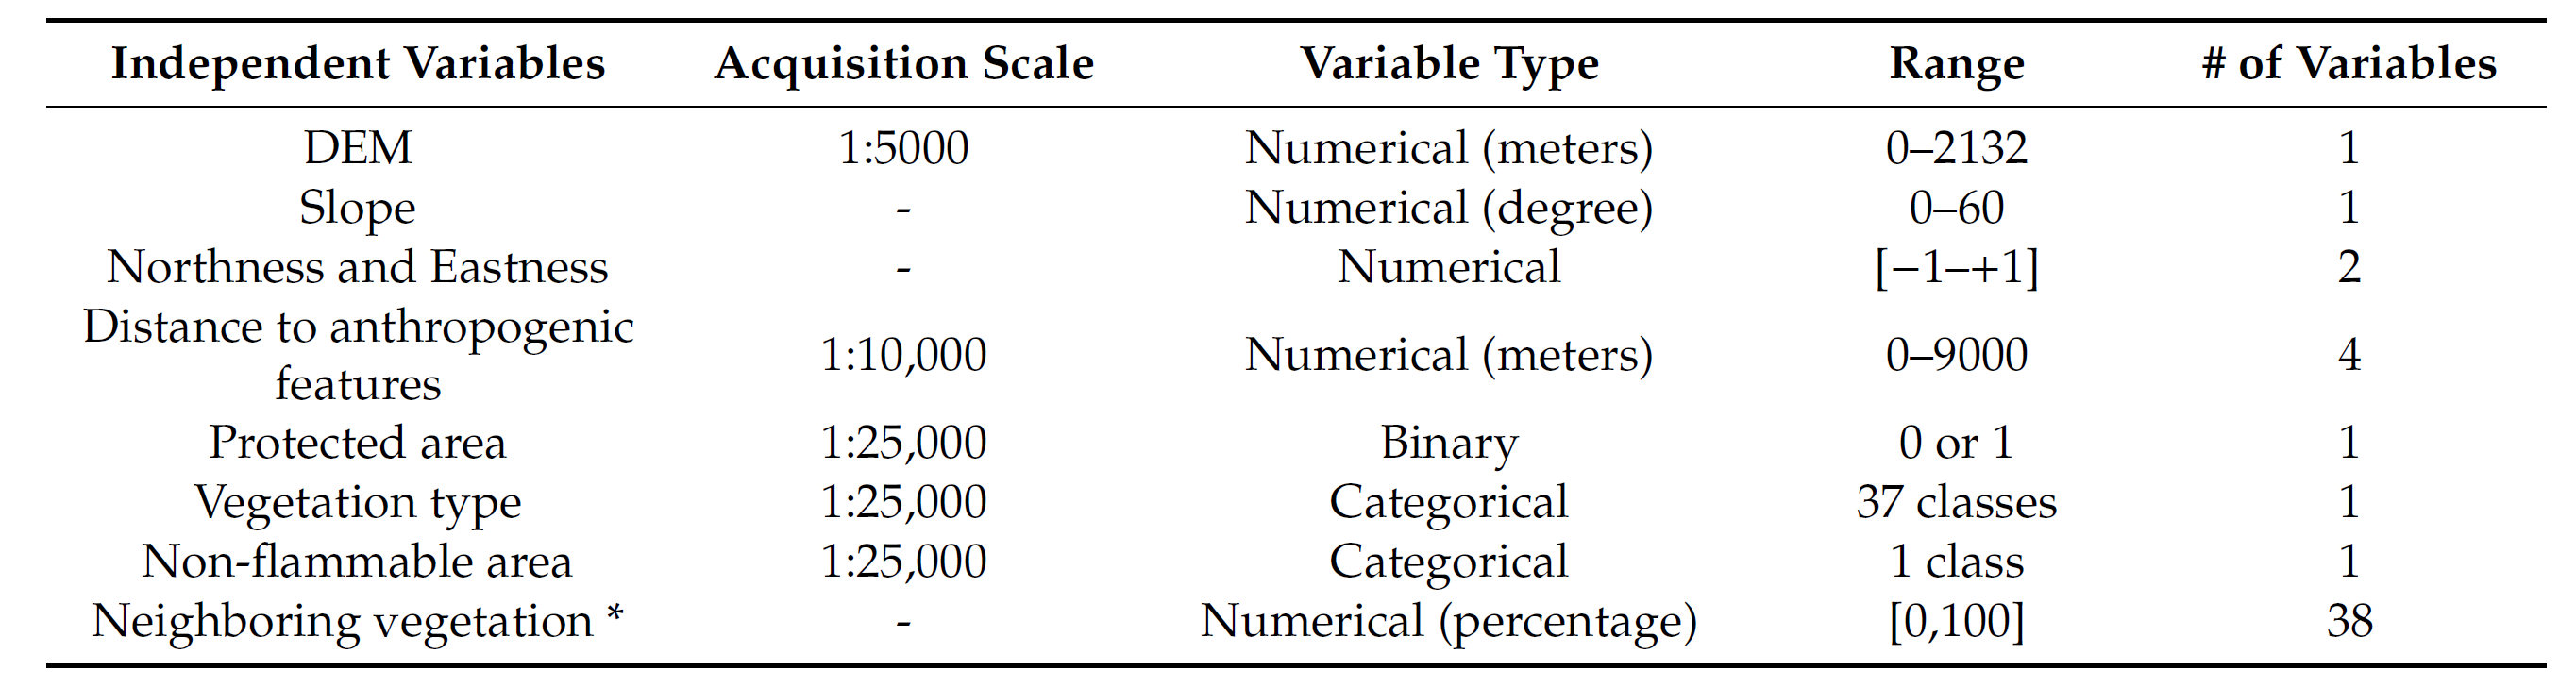

In [5]:
# Explore the `variables` dataset
variables.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 528669 entries, 0 to 519423
Data columns (total 29 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   row          528669 non-null  int64   
 1   col          528669 non-null  int64   
 2   x            528669 non-null  float64 
 3   y            528669 non-null  float64 
 4   dem          528669 non-null  int16   
 5   slope        528669 non-null  float32 
 6   north        528669 non-null  float32 
 7   east         528669 non-null  float32 
 8   veg          528669 non-null  object  
 9   urban_d      528669 non-null  float32 
 10  roads_d      528669 non-null  float32 
 11  crops_d      528669 non-null  float32 
 12  tracks_d     528669 non-null  float32 
 13  bioclim      528669 non-null  object  
 14  phytoclim    528669 non-null  object  
 15  temp_1       528669 non-null  float32 
 16  temp_2       528669 non-null  float32 
 17  prec_1       528669 non-null  float32 
 

In [6]:
# Select the inputs you would like to keep
inputs=variables.iloc[:,[5,8,9,11,13,15,17,18,20,23]]

**Q2) To avoid making inaccurate assumptions about which types of vegetation and non-flammable area are most similar, convert your categorical inputs into one-hot vectors.**

Hint 1: You may use the [`fit_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder.fit_transform) method of `scikit-learn`'s [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) class to convert categorical inputs into one-hot vectors.

Hint 2: Don't forget to remove the categorical variables from your input dataset, e.g. using [`drop`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) if you are still using a `GeoDataFrame`, or [`del`](https://docs.python.org/3/reference/simple_stmts.html#the-del-statement)/[`pop`](https://docs.python.org/3/library/stdtypes.html#dict.pop) if you are working with a Python dictionary. 

In [7]:
# Import the necessary classes and functions
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [8]:
# Convert your categorical inputs into one-hot vectors
cat_attribs = ['veg','bioclim']
cat_pipeline = Pipeline( [ ("cat_encoder", OneHotEncoder(sparse=False)) ] )

In [9]:
# Don't forget to add your one-hot vectors to your `inputs`
preprocess_pipeline = ColumnTransformer( [("cat", cat_pipeline, cat_attribs) ] , remainder='passthrough')

In [10]:
inputs_proc = preprocess_pipeline.fit_transform(inputs)

Now that we built our `inputs` dataset, we are ready to build our `outputs` dataset!

**Q3) Using the `point_index` column of `wildfires` and `variables`, create your `outputs` dataset, containing 1 when there was a wildfire and 0 otherwise.**

Hint: Check that `inputs` and `outputs` have the same number of cases by looking at their `.shape[0]` attribute. 

In [11]:
# Initialize your `outputs` dataset using the `variables` dataset
outputs = np.zeros_like(variables.iloc[:,0])
wildfiresindex = wildfires.index

In [12]:
# Fill it with 0 and 1 using the `wildfire` dataset
for obj in wildfiresindex:
  outputs[obj] = 1

In [13]:
# Check that `inputs` and `outputs` have the same shape[0]
assert inputs.shape[0]==outputs.shape[0]

**Q4) Separate your `inputs` and `outputs` datasets into a training and a test set. Keep at least 20% of the dataset for testing.** 

Hint 1: You may use `scikit-learn`'s [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

Hint 2: If you are considering optimizing the hyperparameters of your classifier, form a validation dataset as well.

In [14]:
# Import the necessary classes and functions
from sklearn.model_selection import train_test_split

In [17]:
# Split your `inputs`/`outputs` datasets into training(/validation)/test sets
all_indices = list(range(len(inputs_proc)))
indx_train,indx_test = train_test_split(all_indices,test_size=0.25,random_state=42)
X_train,X_test,y_train,y_test = inputs_proc[indx_train,:],inputs_proc[indx_test,:],outputs[indx_train],outputs[indx_test]

In [19]:
# Check the shape of your training(/validation)/test sets
# and make sure you kept at least 20% of your dataset for testing
#print(X_train.shape,y_train.shape)
print(indx_test)

[406199, 210823, 13259, 229851, 83047, 444701, 91008, 191764, 492100, 128581, 473834, 335040, 262802, 352409, 97402, 163076, 236606, 46151, 445199, 184816, 333096, 252012, 321377, 82630, 475800, 34761, 45261, 193904, 328744, 449993, 68238, 107422, 319116, 2, 229010, 353991, 195535, 150269, 263478, 416270, 507770, 230622, 68551, 469470, 143187, 15827, 40481, 296533, 241426, 40629, 255337, 277134, 521660, 439211, 49003, 201377, 88412, 51283, 375747, 334913, 360999, 221987, 300530, 200423, 129365, 353983, 317158, 374067, 389853, 381770, 84653, 136885, 123991, 420244, 370373, 57913, 16667, 126211, 172653, 118085, 140009, 197404, 370156, 513137, 77911, 123156, 518841, 474759, 299834, 173630, 122893, 497573, 234314, 335190, 483287, 179969, 477591, 344101, 21983, 230036, 135647, 177079, 19446, 431034, 335611, 299089, 46357, 255630, 3125, 23949, 153891, 525006, 435493, 90490, 495804, 95006, 469653, 326650, 136338, 518544, 11274, 271904, 31700, 309781, 20589, 427475, 115354, 195343, 273481, 195

Congratulations, you have created a viable wildfire dataset to train a machine learning classifier! 😃 Now let's get started 🔥

<a name="previous_ex"></a>
## Part II: Training and Benchmarking the Machine Learning Classifiers

**Q5) Now comes the machine learning fun! 🤖 Train multiple classifiers on your newly-formed training set, and make sure that at least one has the `predict_proba` method once trained.**

Hint: You may train a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), an [`ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), or a [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), but we encourage you to be creative and include additional classifiers you find promising! 💻

In [20]:
# Import the necessary classes and functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

In [21]:
# Train the classifiers on the training set
train_models = {'rf':RandomForestClassifier().fit(X_train,y_train),'etc':ExtraTreesClassifier().fit(X_train,y_train)}

In [ ]:
# (Optional) Conduct a hyperparameter search on the validation set
# e.g., using scikit-learn's RandomizedSearchCV

**Q6) Compare the performance and confusion matrices of your classifiers on the test set. Which classifier performs best in your case?** 

Hint 1: You may use the [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to quantify your classifier's performance, but don't forget there are [many other performance metrics to benchmark binary classifiers](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics). 

Hint 2: You can directly calculate the confusion matrix using `scikit-learn`'s [`confusion_matrix` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). 

In [22]:
# Import the necessary classes and functions
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [23]:
# Calculate the prediction of your classifier(s) over your test set
pred_rf = train_models['rf'].predict(X_test)
pred_etc = train_models['etc'].predict(X_test)

In [24]:
# Infer their performance
print(f'RF accuracy: {accuracy_score(y_test,pred_rf):.3}, ETC accuracy; {accuracy_score(y_test,pred_etc):.3}')

RF accuracy: 0.908, ETC accuracy; 0.904


In [58]:
list([y_test==1][0]).count(True)

18082

In [63]:
# and their confusion matrices
test = confusion_matrix(y_test,pred_rf)
print(test[1,:]/(list([y_test==1][0]).count(True))*100)
print(test[0,:]/(list([y_test==0][0]).count(True))*100)

[51.95774804 48.04225196]
[97.47558859  2.52441141]


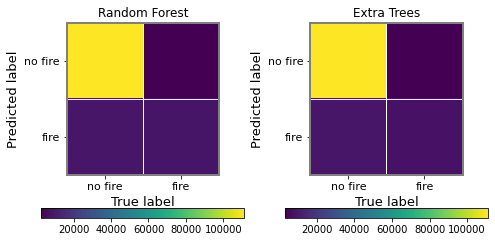

In [25]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(8,4))
cm = confusion_matrix(y_test,pred_rf)
cmploy = ax[0].imshow(cm,cmap='viridis')
plt.colorbar(cmploy,ax=ax[0],orientation="horizontal")
#for i in range(2):
#    for j in range(2):
#        text = ax[0].text(j, i, str(round(cm[i, j]*100,0))+'%',ha="center", va="center", color="w", weight='bold')
ax[0].axhline(y=0.5,ls='-',lw=1,c='w')
ax[0].axvline(x=0.5,ls='-',lw=1,c='w')
ax[0].set_title('Random Forest')
ax[0].set_ylabel('Predicted label',size=13)
ax[0].set_xlabel('True label',size=13)
ax[0].tick_params(axis='both', which='major', labelsize=11)
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['no fire','fire'],size=11)
ax[0].set_yticks([0,1])
ax[0].set_yticklabels(['no fire','fire'],size=11)
[x.set_linewidth(2) for x in ax[0].spines.values()]
[x.set_color('gray') for x in ax[0].spines.values()]

cm = confusion_matrix(y_test,pred_etc)
cmploy = ax[1].imshow(cm,cmap='viridis')
plt.colorbar(cmploy,ax=ax[1],orientation="horizontal")
#for i in range(2):
#    for j in range(2):
#        text = ax[0].text(j, i, str(round(cm[i, j]*100,0))+'%',ha="center", va="center", color="w", weight='bold')
ax[1].axhline(y=0.5,ls='-',lw=1,c='w')
ax[1].axvline(x=0.5,ls='-',lw=1,c='w')
ax[1].set_title('Extra Trees')
ax[1].set_ylabel('Predicted label',size=13)
ax[1].set_xlabel('True label',size=13)
ax[1].tick_params(axis='both', which='major', labelsize=11)
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['no fire','fire'],size=11)
ax[1].set_yticks([0,1])
ax[1].set_yticklabels(['no fire','fire'],size=11)
[x.set_linewidth(2) for x in ax[1].spines.values()]
[x.set_color('gray') for x in ax[1].spines.values()]
plt.show()

For comparison, below is the confusion matrix obtained by the paper's authors:


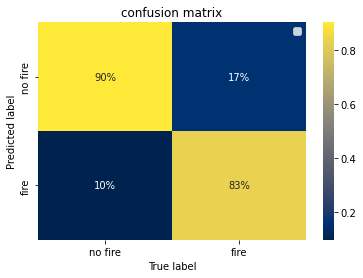

## Part III: Making the Susceptibility Map

**Q7) Using all the classifiers you trained that have a `predict_proba` method, predict the probability of a wildfire over the entire dataset.**

Hint: `predict_proba` will give you the probability of both the presence and absence of a wildfire, so you will have to select the right probability. 

In [26]:
# Predict the probability of a wildfire or not on the test set
predprob_rf = train_models['rf'].predict_proba(X_test)
predprob_etc = train_models['etc'].predict_proba(X_test)

In [27]:
# Extract the probability of a wildfire 
# happening over the entire period of the dataset
# for each instance
rf_testprob_fire = predprob_rf[:,1]

**Q8) Make the susceptibility map 🔥**

Hint 1: The `x` and `y` coordinates for the map can be extracted from the `variables` dataset.

Hint 2: You can simply [`scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) `x` versus `y`, and color the dots according to their probabilities (`c`=probability of a wildfire) to get the susceptibility map.

In [35]:
testx,testy = variables['x'].iloc[indx_test],variables['y'].iloc[indx_test]

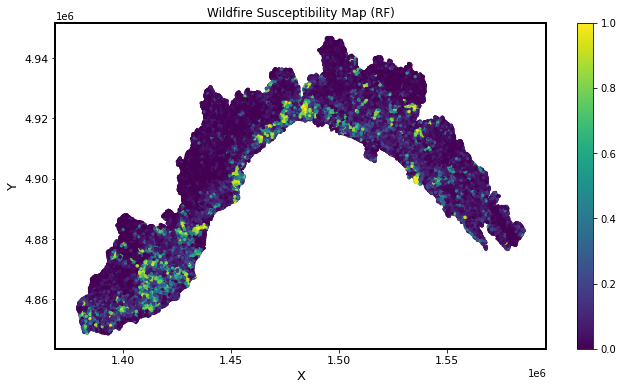

In [44]:
# Scatter x vs y and color the dots with the predicted probability
# to make the susceptibility map
fig,ax = plt.subplots(1,figsize=(6+5,4+2))
cmploy = ax.scatter(testx,testy,s=5,c=rf_testprob_fire,cmap='viridis')
plt.colorbar(cmploy,ax=ax,orientation="vertical")
ax.set_title('Wildfire Susceptibility Map (RF)')
ax.set_ylabel('Y',size=13)
ax.set_xlabel('X',size=13)
ax.tick_params(axis='both', which='major', labelsize=11)
[x.set_linewidth(2) for x in ax.spines.values()]
plt.show()

You should get a susceptibility map that looks like the one below. Does your susceptibility map depend on the classifier & the inputs you chose? Which map would you trust most?

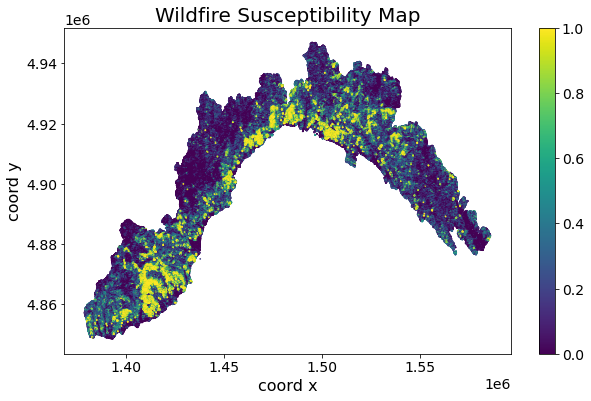

# Bonus Exercise 4: Exploring the Susceptibility Map's Sensitivity to Seasonality and Input Selection

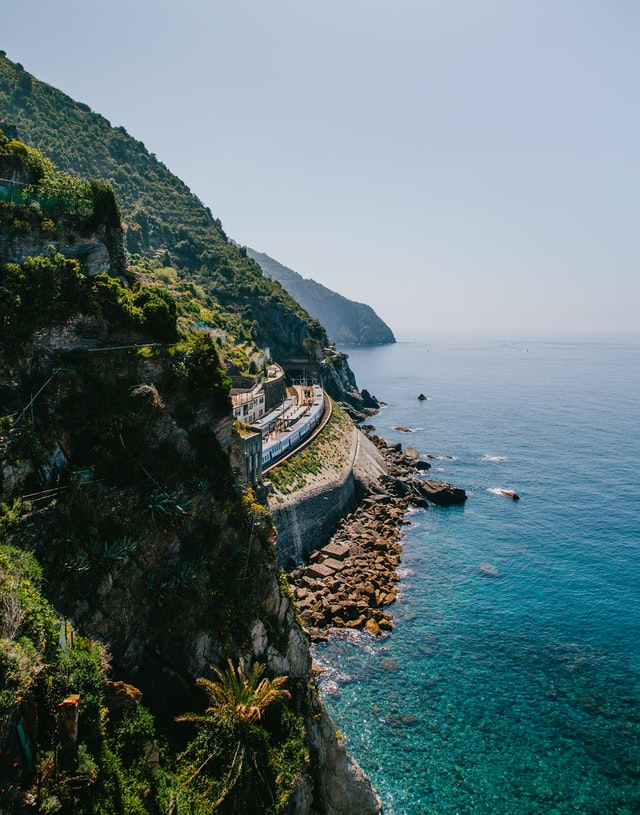

**Caption:** The Liguria region (Cinque Terre), after you save it from raging wildfires using machine learning ✌ 

## Part I: Seasonality

**Q1) Using the `season` column of `wildfires`, separate your data into two seasonal datasets (1=Winter, 2=Summer).**

Hint: When splitting your `inputs` into two seasonal datasets, keep in mind that `temp_1` and `prec_1` are the climatological mean temperatures and precipitation during winter, while `temp_2` and `prec_2` are the climatological mean temperature and precipitation during summer.  

In [ ]:
# Identify indices for which the wildfires occured during winter/summer

In [ ]:
# Use these indices to split your `inputs` and `outputs` datasets 
# into two seasonal datasets

In [ ]:
# Verify that for each season, the shape[0] of your
# `inputs` and `outputs` sets are the same

**Q2) Use these two seasonal datasets to make the Liguria winter and summer susceptibility maps using your best classifier(s). What do you notice?**

Hint: Feel free to recycle as much code as you can from [the previous exercise](#previous_ex). For instance, you may build a library of functions that directly train the classifier(s) and output susceptibility maps!

In [ ]:
# So

In [ ]:
# Much

In [ ]:
# Recycling

In [ ]:
# Compare the winter and summer susceptibility maps

## Part II: Input Selection

The details of the susceptibility map may strongly depend on the inputs you chose from the `variables` dataset. Here, we explore two different ways of selecting inputs to make our susceptibility maps as robust as possible.

**Q3) Using your best classifier, identify the inputs contributing the most to your model's performance using [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html).**

Hint: You may use `scikit-learn`'s [`permutation_importance` function](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) using your best classifier as your `estimator`.

In [ ]:
# Import the necessary functions and classes

In [ ]:
# Calculate the permutation importance of each of your model's inputs

In [ ]:
# Display the result and identify the most important inputs

**Q4) Retrain the same type of classifier only using the inputs you identified as most important, and display the new susceptibility map.**

Hint: Feel free to recycle as much code as you can from [the previous exercise](#previous_ex). For instance, you may build a library of functions that directly train the classifier(s) and output susceptibility maps!

In [ ]:
# Lots

In [ ]:
# of

In [ ]:
# recycling

In [ ]:
# Make the new susceptibility map

Can you explain the differences in susceptibility maps based on the inputs' spatial distribution?

If the susceptibility map changed a lot, our best classifier may initially have learned spurious correlations. This would have affected our permutation feature importance analysis, and motivates re-selecting our inputs from scratch! 🔨

**Q5) Use the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to select the most important inputs. Select as few as possible!**

Hint: Track how the score improves as you add more and more inputs via `n_features_to_select`, and stop when it's "good enough".

In [ ]:
# Import the SequentialFeatureSelector

In [ ]:
# Add more and more inputs

In [ ]:
# How many inputs do you need to get a "good enough" score?

Which inputs have you identified as the most important? Are they the same as the ones you selected using permutation feature importance?

**Q6) Retrain the same type of classifier using as little inputs as possible, and display the new susceptibility map.**

Hint: Feel free to recycle as much code as you can from [the previous exercise](#previous_ex). For instance, you may build a library of functions that directly train the classifier(s) and output susceptibility maps!

In [ ]:
# Recycle your previous code here

In [ ]:
# and here

In [ ]:
# And remake the final susceptibility map

How does it compare to the authors' susceptibility map below?

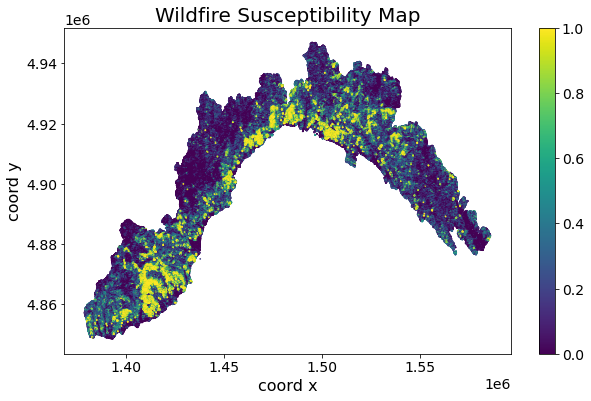